# This is the codebase for choosing the stocks that are used in this experiment based on bins of volatility.

### To do so, we first retreive a list of all tradable us equities that are listed on the alpaca api.

In [3]:
import pandas as pd
import alpaca_trade_api as tradeapi
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Alpaca API credentials
API_KEY = 'PKBYDKFT1P9C7J74JPV2'
API_SECRET = 'c56K2qegiEUAgm5JgbwZGISdr9lDe9cN05kpaHmF'
BASE_URL = 'https://paper-api.alpaca.markets'

# Initialize Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version = 'v2')

# Retrieve a list of all tradable US equities
assets = api.list_assets(status='active')

# Filter for tradable US equities
tickers = []
for asset in assets:
    if asset.tradable and getattr(asset, 'class', None) == 'us_equity':
        tickers.append(asset.symbol)

print(len(tickers))
print(len(set(tickers))) # By printing both length, we can see that their length is equal, which means that there are no duplicate tickers.


11669
11669


In [ ]:
# Past 5 years between 2020-05-08 and 2025-05-07
# The time period that we use for this we are interested in for our experiment.
start_date = '2020-05-08'
end_date = '2025-05-07'
# daily historical stock data
timeframe = tradeapi.TimeFrame.Day

In [12]:
batch_size = 200 # retreive batches of 200 because Alpaca API has a limit of 200 request per minute

df = pd.DataFrame()
for step in range(0, len(tickers), batch_size):
    batch_tickers = tickers[step:step + batch_size]
    try:
        batch_values = api.get_bars(batch_tickers, timeframe, start = start_date, end = end_date, adjustment='all').df
        df = pd.concat([df, batch_values], axis=0)
        print(f"Fetched data for batch {step}: {batch_tickers}")
    except Exception as e:
        print(f"Error fetching data for batch {step}: {e}")
        continue

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/bars 3 more time(s)...


KeyboardInterrupt: 

In [ ]:
df_original = df.copy() # Keep a copy of the original dataframe

In [ ]:
df_original.to_csv('stock_data_full_data.csv', index=True)

In [4]:
# load df from csv
df = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)

In [13]:
# load df_original from csv
df_original = pd.read_csv('stock_data_full_data.csv', index_col=0, parse_dates=True)

In [14]:
df = df_original.reset_index().pivot(index="timestamp", columns="symbol", values="close")

In [ ]:
df.to_csv('stock_data.csv', index=True)

In the following section we preprocess our data set.

In [5]:
missing_values = df.isnull().sum()
#create a new dataframe with the missing values
missing_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Missing_Values'])
missing_df = missing_df.T

missing_df

,AAA,AACB,AACBR,AACBU,AACT,AACT.U,AACT.WS,AAM,AAM.U,AAM.WS,...,ZTEN,ZTOP,ZTRE,ZTWO,ZURA,ZVIA,ZVOL,ZVRA,ZVSA,ZYBT
Missing_Values,85,1234,1234,1198,778,743,778,1095,1064,1095,...,925,1240,925,925,721,303,741,169,444,1173


From the output of the cell above we can clearly see that we have about 5000 stocks and ETFs with missing values. Since we would have about 6000 stocks and ETFs left and we only need a handful the most practical approach for imputation here will be to simply drop the stocks and ETFs with missing values.

Another thing that we need to account for is that when we retrieved the data, we wanted the assets class to be us_equity for every asset that we download the historical data from. us_equity includes all stocks and ETFs. The problem with that is that ETFs include different kinds of Exchange Tradable Funds and some of them have long periods of the same closing price. The reason for that is economic in nature and comes from the machanisms of how ETFs are traded and split but we dont want to go too deep into that at this point. 

One example is the ETF with the ticker symbol WTIU

In [ ]:
df_wtiu = df['WTIU'].copy()

In [ ]:
df_wtiu.head(100)

timestamp
2020-05-08 04:00:00+00:00    0.2121
2020-05-11 04:00:00+00:00    0.2121
2020-05-12 04:00:00+00:00    0.2121
2020-05-13 04:00:00+00:00    0.2121
2020-05-14 04:00:00+00:00    0.2121
                              ...  
2020-09-23 04:00:00+00:00    0.2121
2020-09-24 04:00:00+00:00    0.2121
2020-09-25 04:00:00+00:00    0.2121
2020-09-28 04:00:00+00:00    0.2121
2020-09-29 04:00:00+00:00    0.2121
Name: WTIU, Length: 100, dtype: float64

<Axes: xlabel='timestamp'>

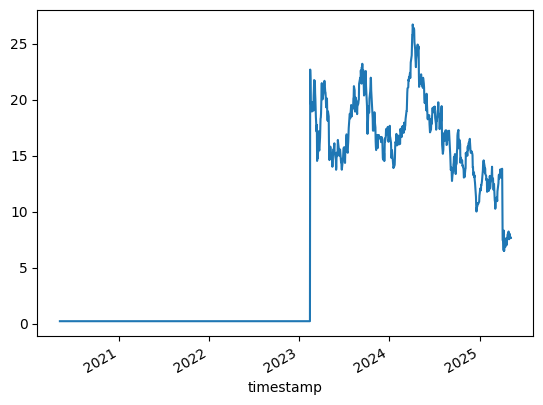

In [18]:
df_wtiu.plot()

This example ETF clearly is one that we dont want to have as part of our analysis first because the volatility score that we calculate would be deducted from the whole period and therefore would not represent the volatility of the actual period where the ETF has been traded which seems to only have begun in 2023. Second we dont want to use this ETF because our models potentially struggle a lot to make sense out of such a course.

Therefore we also want to drop all the stocks and ETFs that have periods of more than 30 days with a constant price.

In [6]:
def has_long_period_with_constant_price(df, threshold=30):

    same_as_previous = df.shift(1) == df
    same_as_previous.iloc[0] = False


    count = 0
    countMax = 0
    for is_same in same_as_previous:
        if is_same:
            count = count +1 
            countMax = max(count, countMax)
        else:
            count = 0
    return countMax >= threshold

In [7]:
# We here remove columns with missing values to see whether we would be left with enough data to pick multiple stocks for one volatility.
for column in df.columns:
    if df[column].isnull().any():
        print(f"Column {column} has missing values.")
        df.drop(column, axis=1, inplace=True)
    elif has_long_period_with_constant_price(df[column]):
        print(f"Column {column} has long period with constant price.")
        df.drop(column, axis=1, inplace=True)
    
# We can see that we are left with about 5000 stocks, which should be enough to pick multiple stocks for each volatility step.

Column AAA has missing values.
Column AACB has missing values.
Column AACBR has missing values.
Column AACBU has missing values.
Column AACT has missing values.
Column AACT.U has missing values.
Column AACT.WS has missing values.
Column AAM has missing values.
Column AAM.U has missing values.
Column AAM.WS has missing values.
Column AAPB has missing values.
Column AAPD has missing values.
Column AAPG has missing values.
Column AAPR has missing values.
Column AAPU has missing values.
Column AAPW has missing values.
Column AAPX has missing values.
Column AAPY has missing values.
Column AARD has missing values.
Column ABAT has missing values.
Column ABCL has missing values.
Column ABCS has missing values.
Column ABHY has missing values.
Column ABIG has missing values.
Column ABL has missing values.
Column ABLD has missing values.
Column ABLLL has missing values.
Column ABLLW has missing values.
Column ABLS has missing values.
Column ABLV has missing values.
Column ABLVW has missing values

KeyboardInterrupt: 

Having preprocessed our data we can now proceed to calculate the actual volatility

We want to calculate the volatility using the standard deviation of logarithmic returns, but only the volatility is not enough.
If we had a stock that has a volatility score of lets say 2 for every data point for 5 years of historical data then the total volatility of that stock would be 2. If we had another stock that has a volatility of 0 for the first half of the data points, and a volatility of 4 for the second half of the data points then the total volatility for that stock would also be 2 even though the 2 stocks have strongly differing characteristics. So besides the pure volatility we introduce the volatility of volatility which is supposed to tell us whether oscillation varies strongly or rather stays the same. We then will use this volatility of volatility to filter out all stocks and ETFs that have a strongly varying volatility. Refering to our research question we want to evaluate how well different ML models perform for stock data with different volatilities. For that we want to have stocks and ETFs that when they have a total volatility score of 2, actually most of the data points have a volatility of 2 instead of having a total volatility of 2 but then having a volatility of zero for half of the data points and a volatility of 4 for the other half of the data points as in the previous example. So to ensure that we can only keep stocks and ETFs with a low volatility of volatility and thus a more constant volatility throughout the course.

In [ ]:
def volatility_pipeline(df):
    
    window = 75
    logarithmic_returns = np.log(df / df.shift(1))
    standard_deviation_windows = logarithmic_returns.rolling(window).std()
    mean_standard_deviation_windows = pd.DataFrame()
    mean_standard_deviation_windows['sample_standard_deviation_of_logarithmic_returns'] = logarithmic_returns.std() # this is the total volatility
    volatility_of_volatility = standard_deviation_windows.std()
    mean_standard_deviation_windows['volatility_of_volatility'] = volatility_of_volatility
    mean_standard_deviation_windows = pd.DataFrame(mean_standard_deviation_windows).T

    return mean_standard_deviation_windows


In [ ]:
volatility_df = volatility_pipeline(df)

In [23]:
import pickle
with open(f'volatility_df.pkl', 'wb') as f:
    pickle.dump(volatility_df, f)

In [8]:
import pickle
with open(f'volatility_df.pkl', 'rb') as f:
    volatility_df = pickle.load(f)

In [9]:
print(volatility_df.shape)
volatility_df

(2, 6142)


symbol,A,AA,AAAU,AACG,AADR,AAL,AAME,AAMI,AAOI,AAON,...,ZROZ,ZS,ZSL,ZTO,ZTR,ZTS,ZUMZ,ZWS,ZYME,ZYXI
sample_standard_deviation_of_logarithmic_returns,0.017459,0.037336,0.009528,0.089481,0.013950,0.034453,0.048125,0.023190,0.064318,0.024063,...,0.015217,0.035674,0.040141,0.025861,0.011308,0.016464,0.032566,0.028696,0.040227,0.046726
volatility_of_volatility,0.003664,0.005715,0.001471,0.061818,0.002738,0.008206,0.020882,0.005276,0.020865,0.006653,...,0.003025,0.009779,0.009847,0.007155,0.003531,0.003199,0.004073,0.015380,0.012223,0.014428


We understood before that for any bin of volatility we prefer stocks that have a constant volatility or in other words a low volatility of volatility. To find out what volatility of volatility we can accept we need to visualize our data and define for ourselfs when we can say that the volatility of a stock or ETF ist constant.

In [ ]:
volatility_df = volatility_df.sort_values(by='volatility_of_volatility', axis=1, ascending=True)
volatility_df

,TFLO,USFR,ICSH,FTSM,JPST,GSY,GSST,JMST,MINT,TBLL,...,GORO,VTGN,KPLTW,CELUW,BHVN,ILLRW,GDC,TPST,CLEU,APRE
sample_standard_deviation_of_logarithmic_returns,0.000236,0.000298,0.000314,0.000315,0.000360,0.000375,0.000438,0.000520,0.000370,0.000357,...,0.091808,0.099998,0.157991,0.164761,0.092883,0.203192,0.126815,0.129075,0.145041,0.134578
volatility_of_volatility,0.000054,0.000059,0.000066,0.000077,0.000079,0.000101,0.000108,0.000155,0.000157,0.000173,...,0.066053,0.066776,0.068202,0.070982,0.074917,0.082988,0.083100,0.097476,0.098892,0.109205


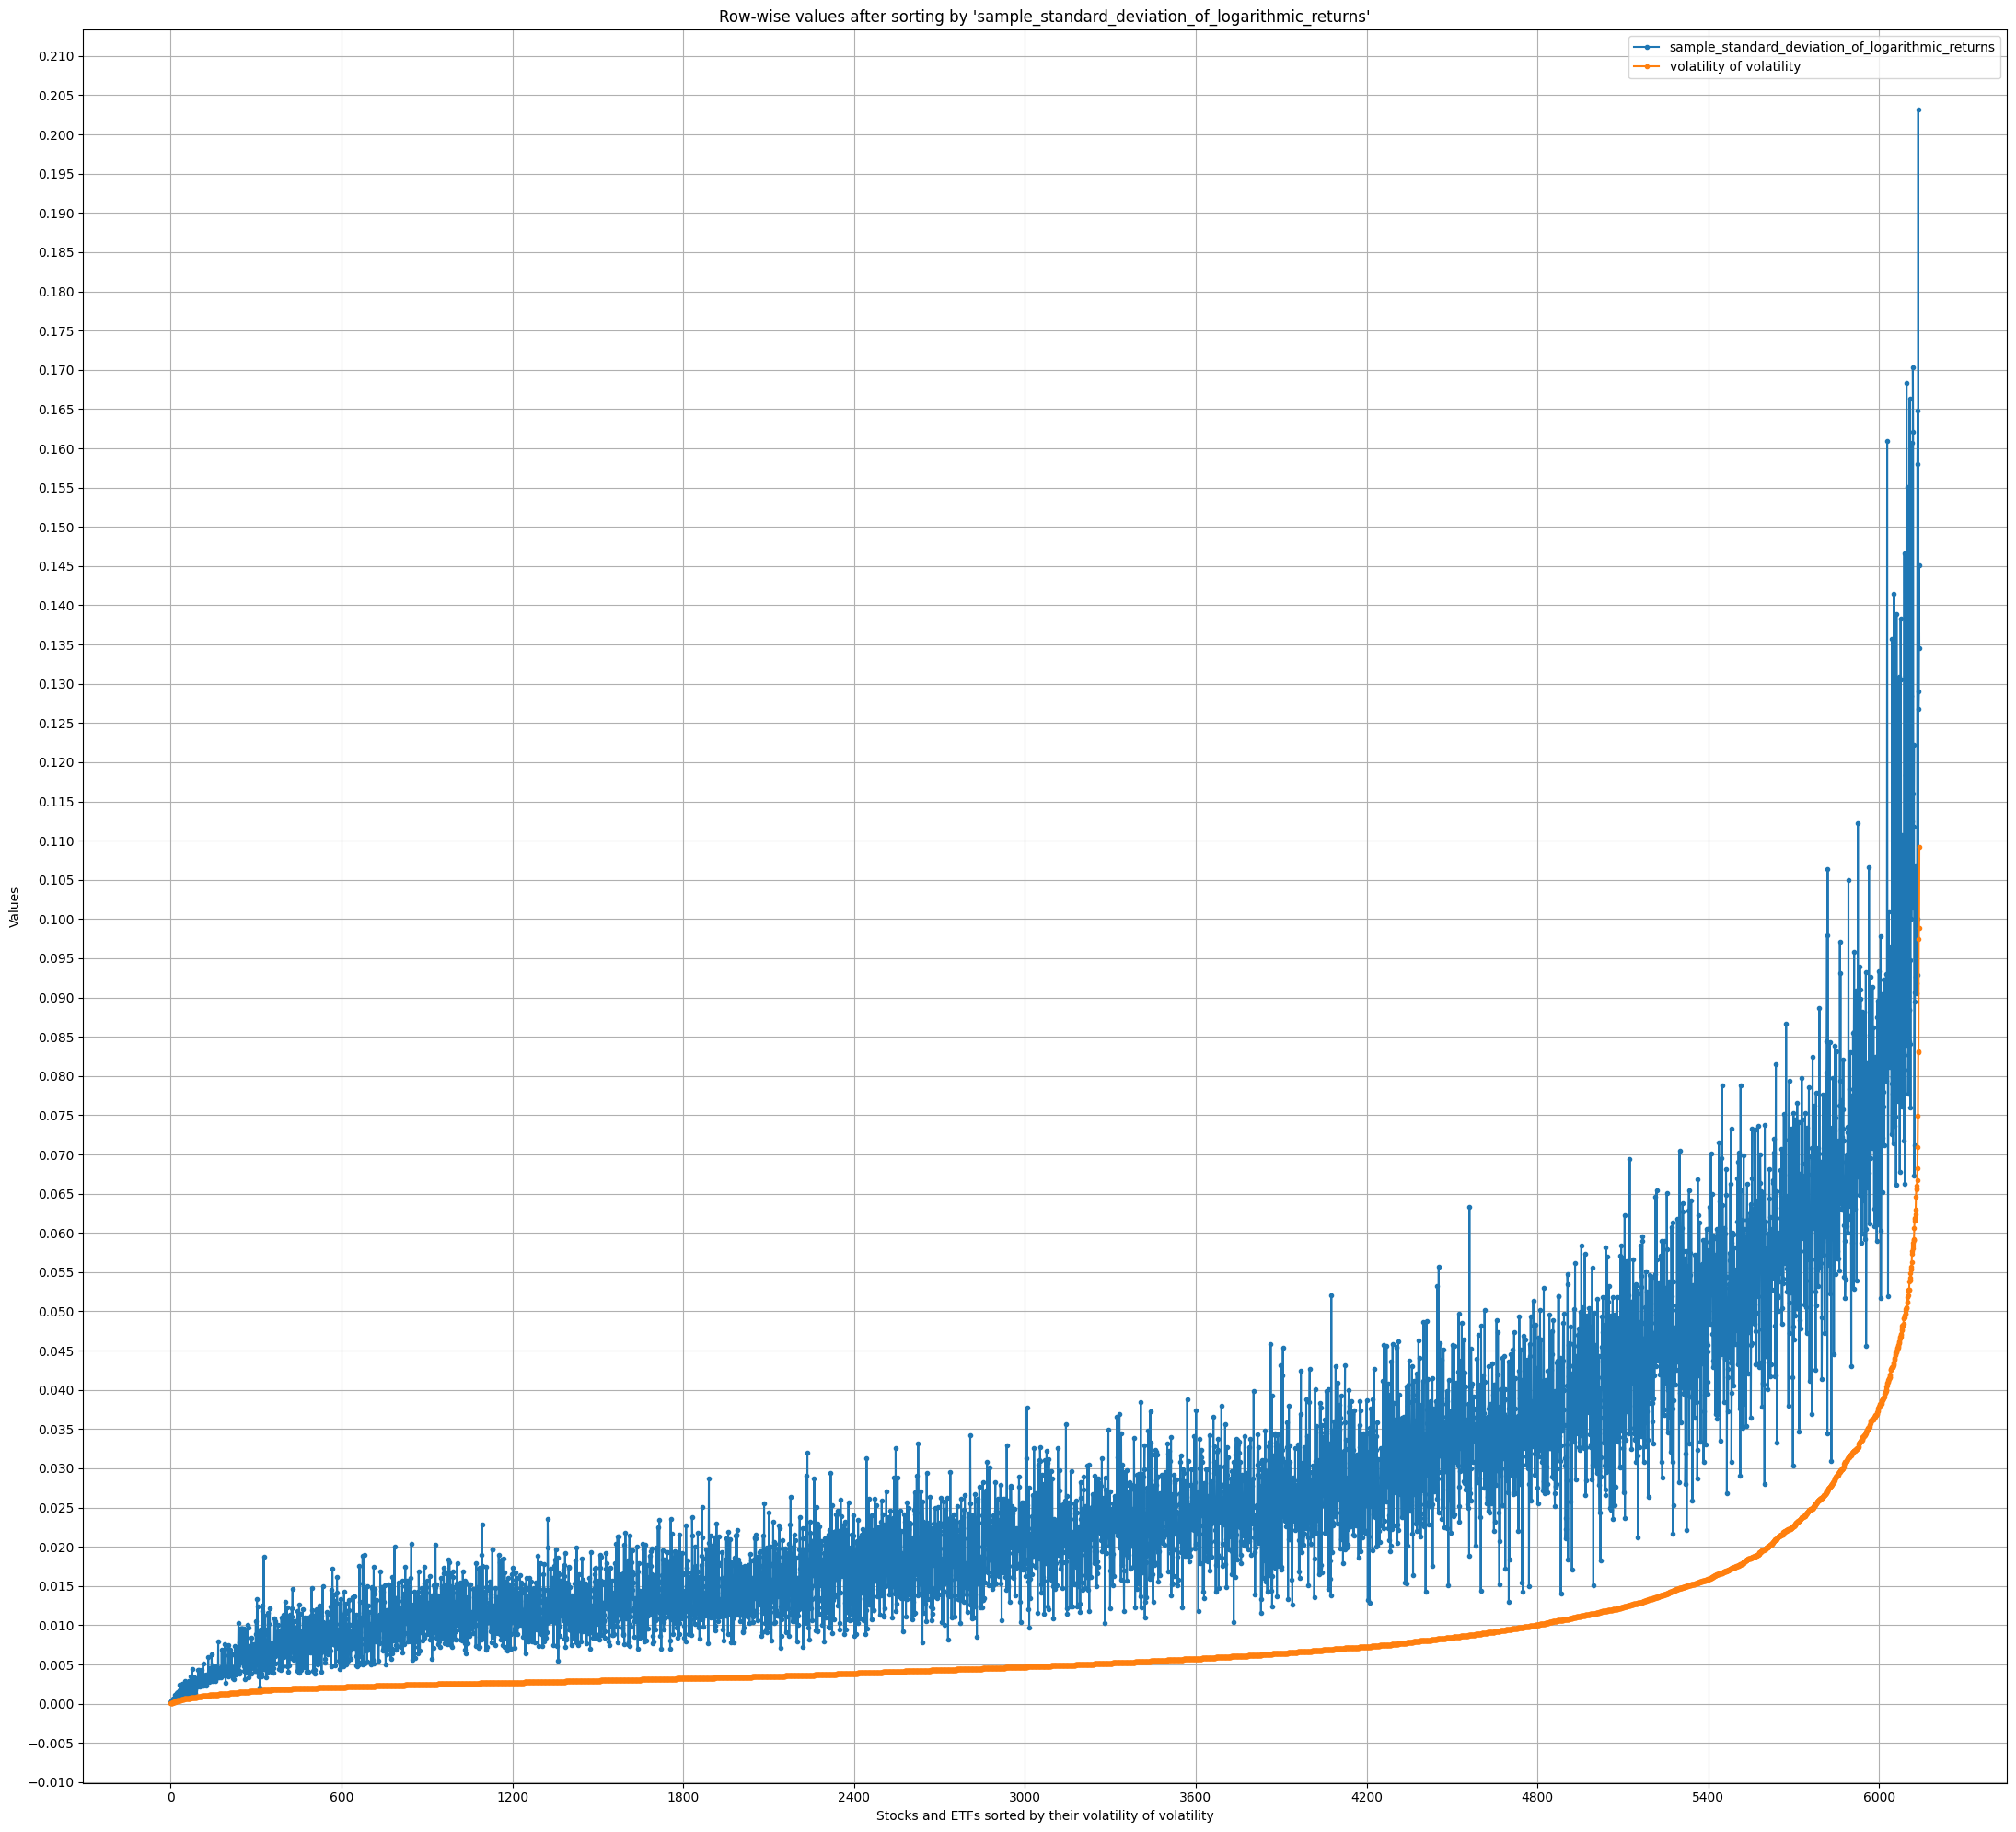

In [35]:
from matplotlib.ticker import MultipleLocator

x = range(len(volatility_df.columns))

plt.figure(figsize=(22, 20))
plt.plot(x, volatility_df.loc['sample_standard_deviation_of_logarithmic_returns'], label='sample_standard_deviation_of_logarithmic_returns', marker='.')
plt.plot(x, volatility_df.loc['volatility_of_volatility'], label="volatility of volatility", marker='.')
plt.xlabel("Stocks and ETFs sorted by their volatility of volatility")
plt.ylabel("Values")
plt.title("Row-wise values after sorting by 'sample_standard_deviation_of_logarithmic_returns'")

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(600))
ax.yaxis.set_major_locator(MultipleLocator(0.005))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the plot we can nicely see that the volatility of volatility seems to be similar for a lot of stocks and very high for a small number of stocks which in and of itself are more volatile compared to the other stocks. We can see that about 4800 stocks and ETFs have a volatility of volatility within 0.000 - 0.010. We decide to define 0.01 as threshold for the volatility of the volatility for our stocks and ETFs. This threshold allows for analyzing stocks and ETFs which have a volatility that doesnt change as much throughout the course while still being able to pick multiple stocks and ETFs with a volatility of up to 0.0475. That seems to be a good trade off, so we will drop every stock or ETF that has a volatility of its volatility of more than 0.01.

In [36]:
for column in volatility_df.columns:
    if volatility_df[column]['volatility_of_volatility'] > 0.01:
        volatility_df.drop(column, axis=1, inplace=True)

In [37]:
volatility_df.shape

(2, 4794)

We see that we are left with 4800 stocks and ETFs of which we want to create volatility bins that are each filled with a handful of historical stock or ETF data.

In [38]:
bin_size = 0.005


volatilities = volatility_df.iloc[0].values.flatten()
highest_volatility = np.max(volatilities)
bins = np.arange(0, highest_volatility+bin_size, bin_size)
binned_volatilities = pd.cut(volatilities, bins=bins, right=False)
binned_volatilities_counts = pd.Series(binned_volatilities).value_counts().sort_index()

In [39]:
binned_volatilities_counts

[0.0, 0.005)      285
[0.005, 0.01)     631
[0.01, 0.015)    1147
[0.015, 0.02)     855
[0.02, 0.025)     789
[0.025, 0.03)     509
[0.03, 0.035)     297
[0.035, 0.04)     180
[0.04, 0.045)      62
[0.045, 0.05)      33
[0.05, 0.055)       4
[0.055, 0.06)       1
[0.06, 0.065)       1
Name: count, dtype: int64

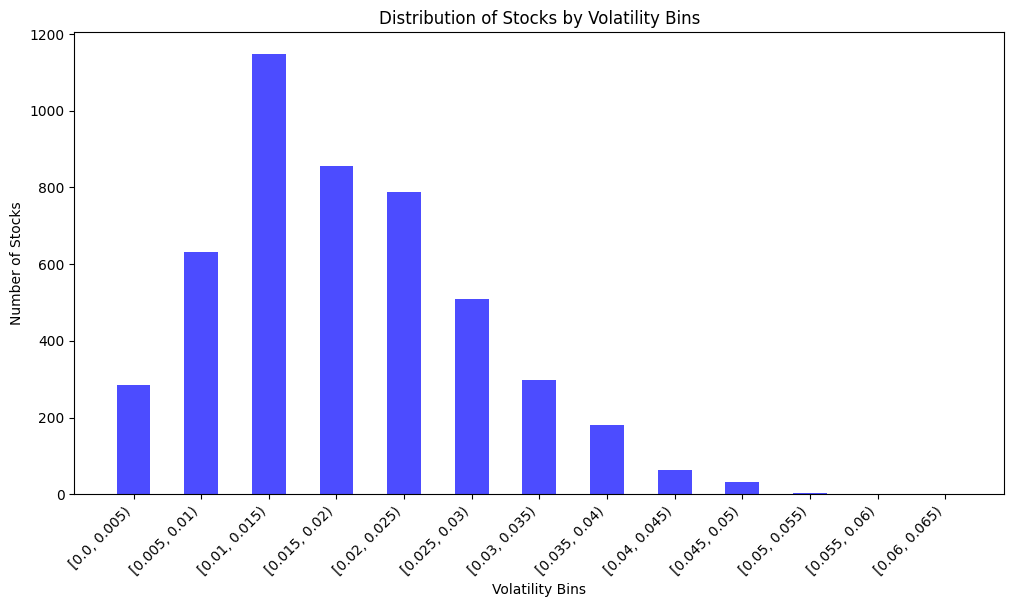

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(binned_volatilities_counts.index.astype(str), binned_volatilities_counts.values, width=0.5, color='blue', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Volatility Bins')
plt.ylabel('Number of Stocks')
plt.title('Distribution of Stocks by Volatility Bins')
plt.show()

We have to define the ranges for our bins manually in a way so that we have 15 stocks in each bin

To make the results as meaningful as possible we define the ranges for our bins in a way so that we capture the widest possible range of volatility. In other words we want bin1 and bin5 to be as far apart as possible and the remaining 3 bins to be in between them while having equal distances to their neighbors. At the same time we want the stocks and ETFs within one bin to be as similar as possible in terms of their volatility. We therefore chose to pick the following ranges:

In [41]:
first_row = volatility_df.iloc[0]

bin1 = volatility_df.loc[:, (first_row >= 0.00235) & (first_row <= 0.0027)]
bin2 = volatility_df.loc[:, (first_row >= 0.01243) & (first_row <= 0.01248)]
bin3 = volatility_df.loc[:, (first_row >= 0.022425) & (first_row <= 0.0225)]
bin4 = volatility_df.loc[:, (first_row >= 0.032416) & (first_row <= 0.0326)]
bin5 = volatility_df.loc[:, (first_row >= 0.045) & (first_row <= 0.046)]

print(bin1.shape)
print(bin2.shape)
print(bin3.shape)
print(bin4.shape)
print(bin5.shape)

(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)


In [42]:
bin1.to_csv('bin1_stocks.csv', index=True)
bin2.to_csv('bin2_stocks.csv', index=True)
bin3.to_csv('bin3_stocks.csv', index=True)
bin4.to_csv('bin4_stocks.csv', index=True)
bin5.to_csv('bin5_stocks.csv', index=True)

In [43]:
bin1 = pd.read_csv('bin1_stocks.csv', index_col=0)
bin2 = pd.read_csv('bin2_stocks.csv', index_col=0)
bin3 = pd.read_csv('bin3_stocks.csv', index_col=0)
bin4 = pd.read_csv('bin4_stocks.csv', index_col=0)
bin5 = pd.read_csv('bin5_stocks.csv', index_col=0)

In [44]:
def plot_bin(bin_df, bin_name):
    plt.figure(figsize=(12, 6))
    plt.plot(bin_df.index, bin_df.iloc[:, :], label=bin_name, marker='.')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'Volatility of Stocks in {bin_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

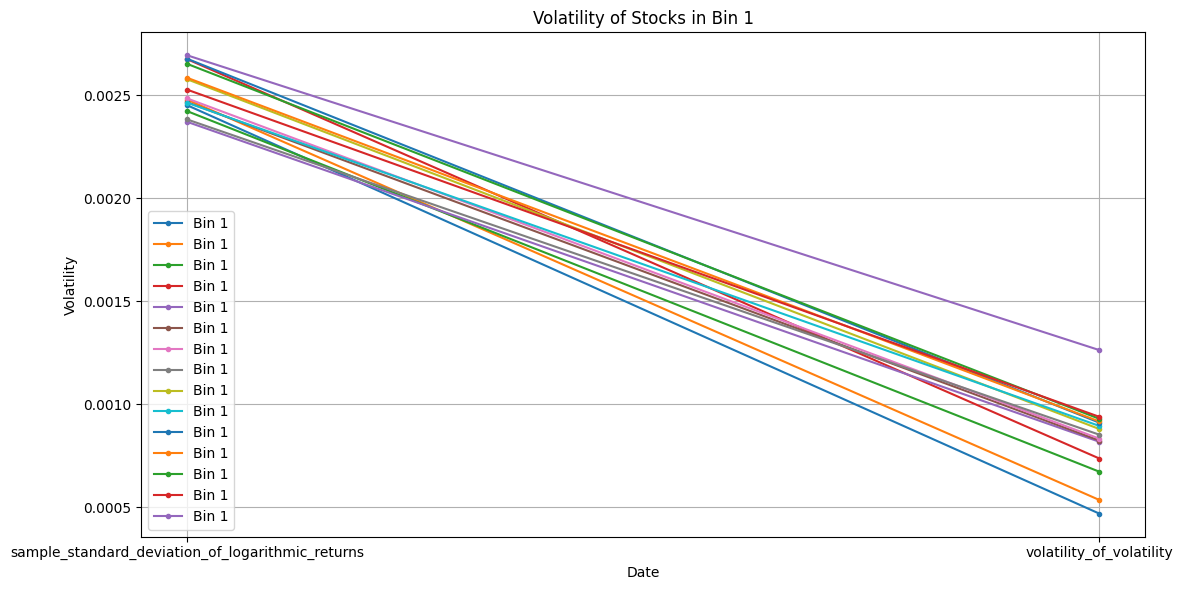

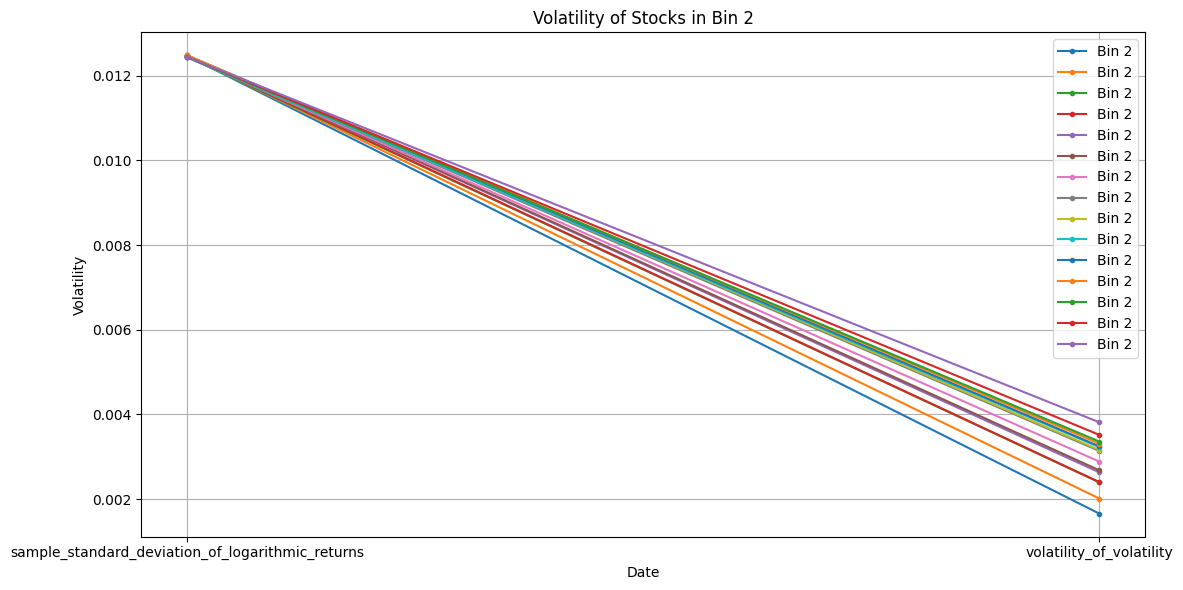

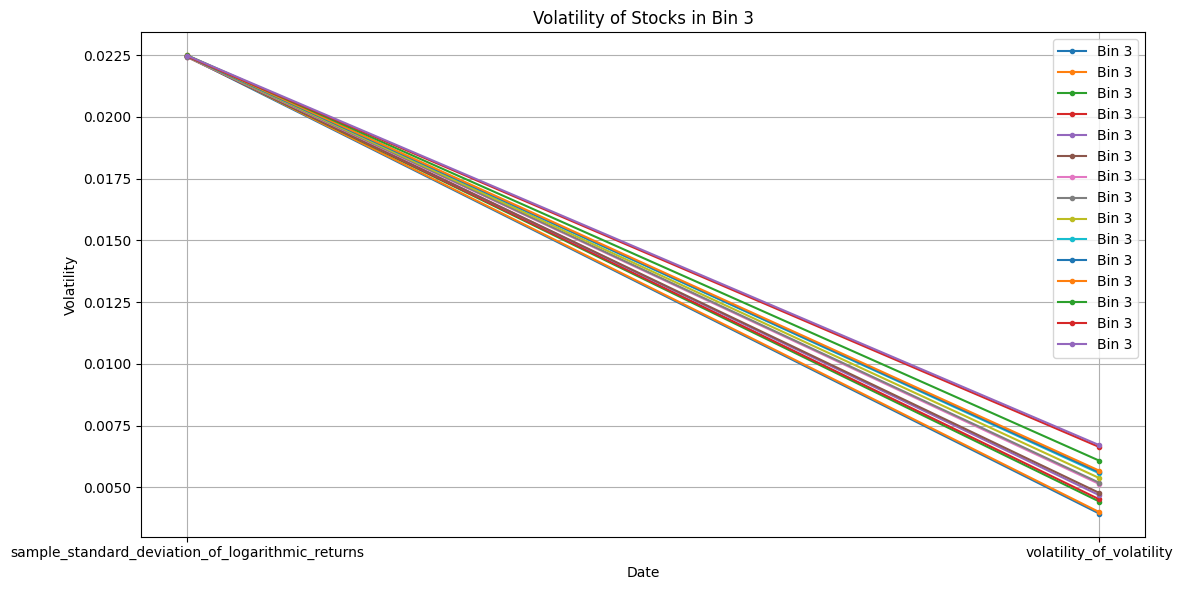

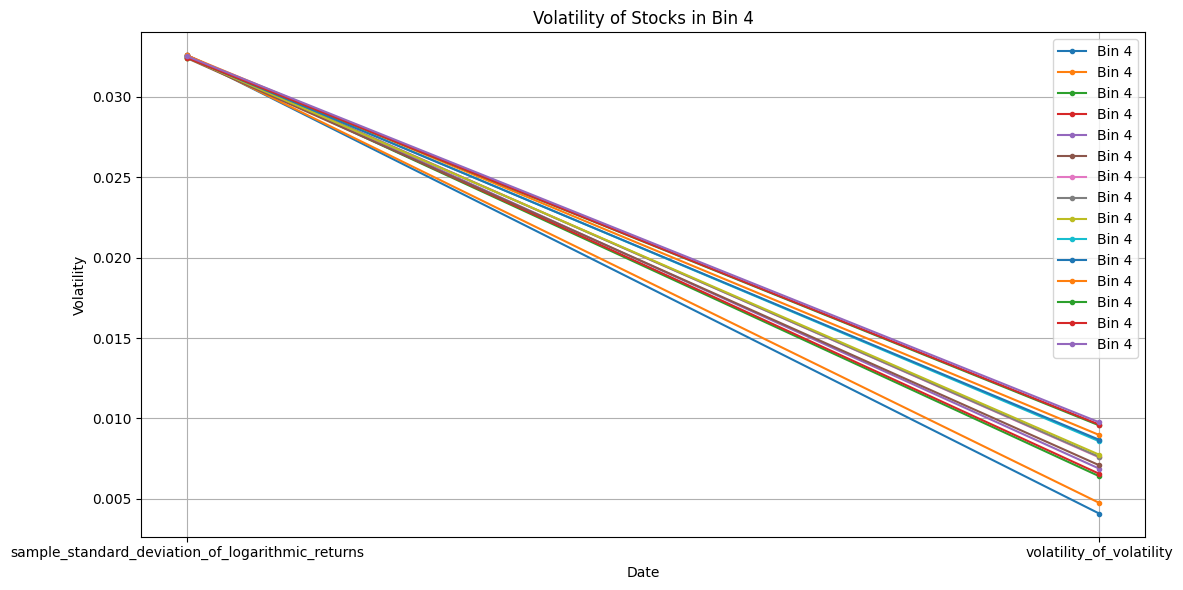

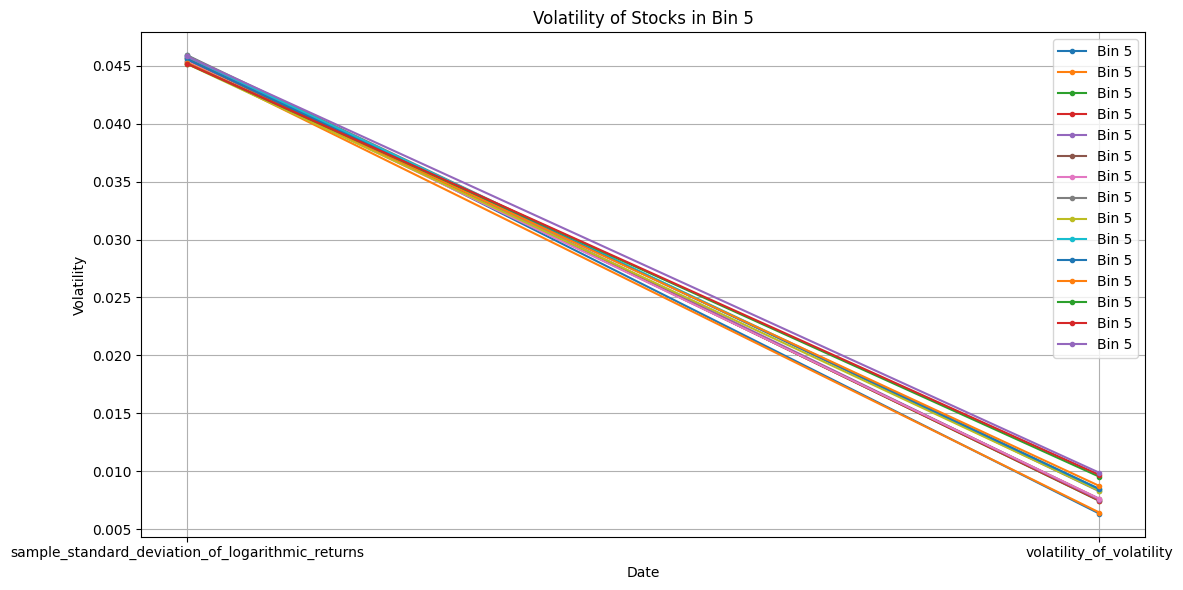

In [45]:
plot_bin(bin1, 'Bin 1')
plot_bin(bin2, 'Bin 2')
plot_bin(bin3, 'Bin 3')
plot_bin(bin4, 'Bin 4')
plot_bin(bin5, 'Bin 5')